This is a 1 cell model with a PN cell and tone and shock inputs, in the configuration shown below
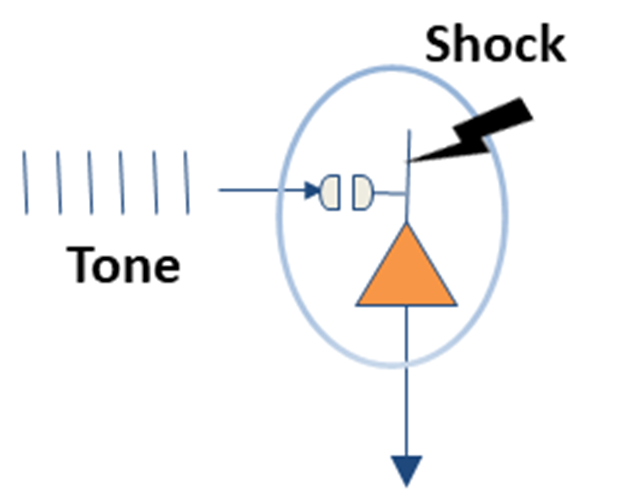

In [1]:
#@title Run cell to activate model
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min")
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron==8.0.0 &> /dev/null
    !pip install ipywidgets==7.7.1 &> /dev/null # installs Neuron
    root = 'Fear-Lesson-Plans'
    folder = '1_cell_model'
    pathlist = normpath(os.getcwd()).split(sep)
    if pathlist[-1] != folder:
      rootidx = pathlist.index(root) if root in pathlist else -1
      if rootidx>0:
        os.chdir(join(sep,*pathlist[:rootidx]))
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git &> /dev/null 
      os.chdir(join(root,folder))
#print(os.getcwd())
os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.

import matplotlib.pyplot as plt
from neuron import h
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline
h.load_file('stdrun.hoc')

h.dt = 0.1 # time step (resolution) of the simulation in ms
h.tstop = 1700 # how long to run the simulation in ms
h.v_init= -65 # initial membrane potential in mV

soma = [h.Section(name='soma[%d]'% i) for i in range(1)] # makes one soma called soma[0]
#print(soma[0].psection())
for i in range(1):
    soma[i].insert("hh")
    soma[i].diam = 30 # micrometers
    soma[i].L = 30 # micrometers
    soma[i].cm = 1 # membrane capacitance uF/cm2
    soma[i].Ra = 25 # ohm-cm
    
#h.topology()

#pyr2pyr0 = h.pyr2pyr(soma[0](0.5))

tone2pyr0 = h.pyr2pyr(soma[0](0.9)) # makes a syn connected to soma

shock2pyr0 = h.pyr2pyr(soma[0](0.8))


t = h.Vector()      # Vectors are used to record data in the simulation
Soma_v = h.Vector()
i_nmda = h.Vector()
capoolcon = h.Vector()
W = h.Vector()

t.record(h._ref_t)                # derefences and records data
Soma_v.record(soma[0](0.5)._ref_v)
i_nmda.record(tone2pyr0._ref_inmda)
capoolcon.record(tone2pyr0._ref_capoolcon)
W.record(tone2pyr0._ref_W)

def plot_variables(): # plots stuff
    fig = plt.figure(figsize=(13,8))
    ax11 = fig.add_subplot(221); ax12 = fig.add_subplot(222)
    ax21 = fig.add_subplot(223); ax22 = fig.add_subplot(224)

    ax11.plot(t, Soma_v)
    ax11.legend(['Soma Vm'],loc=1)
    ax11.set_ylabel('Voltage (mV)')
    ax11.set_xlabel('time (ms)')

    ax12.plot(t ,i_nmda)
    ax12.legend(['i_nmda'],loc=1)
    ax12.set_ylabel('current')
    ax12.set_xlabel('time')

    ax21.plot(t, (capoolcon*1000))
    ax21.legend(['Capoolcon'],loc=1)
    ax21.set_ylabel('concentration')
    ax21.set_xlabel('time')

    ax22.plot(t, W)
    ax22.legend(['Weight'])
    ax22.set_ylabel('Weight')
    ax22.set_xlabel('time')

    plt.show()

def activemodel(initW_tone, initW_shock, thres1, thres2,tone,shock):
    weight_tone = initW_tone
    if (weight_tone == 0):
        weight_tone = 0.0000000001
        
    weight_shock = initW_shock
    if (weight_shock == 0):
        weight_shock = 0.00000000001
        
    tone_freq = tone
    shock_freq = shock
    
    tone2pyr0.initW = weight_tone
    tone2pyr0.threshold1 = thres1
    tone2pyr0.threshold2 = thres2
    soma[i].diam = 30
    
    nstim_tone = h.NetStim(0.9) # makes spike trains
    if (tone_freq != 0):
        nstim_tone.interval=(1000/tone_freq) # ms (mean) time between spikes
        nstim_tone.start = 100               # ms (most likely) start time of first spike
    else:
        nstim_tone.interval=0
        nstim_tone.start = 10000            # way to make the tone freq 0 during stim time
    nstim_tone.number = 100                 # (average) number of spikes
    nstim_tone.noise = 0                    # range 0 to 1. Fractional randomness.
    nc_tone = h.NetCon(nstim_tone,tone2pyr0,0,0,1)    # connects tone to soma via tone2pyr syn
    
    shock2pyr0.initW = weight_shock
    nstim_shock = h.NetStim(0.9)
    if (shock_freq != 0):
        nstim_shock.interval=(1000/shock_freq)
        nstim_shock.start = 300
    else:
        nstim_shock.start=10000
    nstim_shock.number = 100
    nstim_noise = 0 
    nc_shock = h.NetCon(nstim_shock,shock2pyr0,0,0,1)
    
    h.run()
    plt.close('all')
    plot_variables()

initW = 1
thres1 = 0.35
thres2 = 0.4
diam = 30
tone_freq = 20
shock_freq = 40

w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_initW_tone = widgets.FloatSlider(value=1, min=0, max=2, step=0.2)
w_initW_shock = widgets.FloatSlider(value=1, min=0, max=10, step=0.2)
w_tone_f = widgets.IntSlider(description='Tone Freq',value=20, min=0, max=80, step=5)
w_shock_f = widgets.IntSlider(description='Shock Freq',value=40, min=0, max=80, step=5)
w_thres1 = widgets.FloatSlider(value=0.35, min=0.01, max=1, step=0.05)
w_thres2 = widgets.FloatSlider(value=0.4, min=0.01, max=1, step=0.05)

def reset_default(*args):
    w_initW_tone.value = initW
    w_initW_shock.value = initW
    w_thres1.value = thres1
    w_thres2.value = thres2
    w_tone_f.value = tone_freq
    w_shock_f.value = shock_freq
    
w_reset.on_click(reset_default)


labels = ['Tone Weight', 'threshold1', 'threshold2', 'Shock Weight']
Labels = [Label(L) for L in labels]
ui = VBox([ HBox([w_reset]),HBox([w_tone_f, w_shock_f]), HBox([Labels[0],w_initW_tone, Labels[3],w_initW_shock]), 
           HBox([Labels[1], w_thres1, Labels[2],w_thres2])])
out = interactive_output(activemodel, {'initW_tone':w_initW_tone,'initW_shock':w_initW_shock,
                                       'thres1': w_thres1, 'thres2': w_thres2, 
                                       'tone':w_tone_f,'shock':w_shock_f })

display(ui,out)




Output()